<div><img style="float: right; width: 100px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />

<i><small>Última actualización: 2025-03-31</small></i></div>

***

# Evasion Attacks against Machine Learning

Este tutorial esta basado principalmente en el [tutorial](https://secml.readthedocs.io/en/v0.15/tutorials/03-Evasion.html) ofrecido por el equipo creador de SecML, liderado por Battista Biggio, pionero en el análisis de seguridad de algoritmos de Machine Learning.

Aunque el tutorial original utiliza un clasificador SVM con kernel Radial Basis Function (RBF), en nuestra implementación hemos optado por utilizar una red neuronal debido a sus propiedades de diferenciabilidad, lo que facilita los ataques basados en gradientes. El principio del ataque sigue siendo el mismo: encontrar la perturbación mínima necesaria para cruzar la frontera de decisión del clasificador.

Los ataques de evasión consisten en modificar una muestra de tal manera que el clasificador ofrezca una etiqueta diferente a la muestra original. Existen muchos métodos para realizar este tipo de ataque pero en la mayoría de los casos se basan en problemas de optimización basados en *gradiant-descent* sobre la muestra original hasta que se consigue que el resultado de la función de clasificador pase la frontera definida entre las clases (*threshold*). En estos ejemplos vamos a realizar los cambios sobre un dataset aleatorio. Además, aunque vamos a definir la cantidad máxima de cambios que es capaz de realizar el atacante, en el mundo real existen muchas más restricciones sobre los cambios que se pueden realizar. Por un lado, es posible que el atacante no sea capaz de realizar modificaciones a ciertas características que se evaluan o que incluso esos valores no se puedan dar en el mundo real. Por ello es muy importante evaluar las modificaciones que se realizan a la muestra para ver si serían viables en el mundo real.


In [1]:
import sys
sys.version

'3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]'

In [2]:
import numpy as np
import foolbox as fb
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# semilla aleatoria para reproducibilidad
RANDOM_SEED = 42 # 42 es la respuesta a la vida, el universo y a todo según la guía del autoestopista galáctico
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

En primer lugar generamos un dataset con tres posibles etiquetas basadas en tres centros. Dividimos el dataset en entrenamiento y validación y pasamos a entrenar un modelo de red de neuronas simple.

In [3]:
# paso 1. generación del dataset
n_features = 2
n_samples = 1100
centers = [[-2, 0], [2, -2], [2, 2]]
cluster_std = 0.8

X, y = make_blobs(n_samples=n_samples, n_features=n_features,
                  centers=centers, cluster_std=cluster_std, random_state=RANDOM_SEED)

# paso 2. train-test split
n_tr = 1000
n_ts = 100
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=n_tr, test_size=n_ts, random_state=RANDOM_SEED)

# paso 3. normalizamos
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
# paso 4. crear red e hiperparametros
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

input_size = n_features
hidden_size = 32
num_classes = 3
num_epochs = 200
batch_size = 128
learning_rate = 0.01

# datos a torch.XTensor
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# instanciamos, perdida y optimizador como siempre
model = NeuralNetwork(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [5]:
print("Entrenando la red neuronal...")
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward y optimización
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = accuracy_score(y_test.astype(int), predicted.numpy())
    print(f'Precisión en el conjunto de prueba: {accuracy:.2%}')

Entrenando la red neuronal...
Epoch [20/200], Loss: 0.3693
Epoch [40/200], Loss: 0.0394
Epoch [60/200], Loss: 0.0259
Epoch [80/200], Loss: 0.0238
Epoch [100/200], Loss: 0.0231
Epoch [120/200], Loss: 0.0227
Epoch [140/200], Loss: 0.0225
Epoch [160/200], Loss: 0.0223
Epoch [180/200], Loss: 0.0221
Epoch [200/200], Loss: 0.0220
Precisión en el conjunto de prueba: 100.00%


## Creando Ejemplos Maliciosos

Los ejemplos maliciosos utilizados en este tutorial utilizan principalmente el método de gradient-descent y están basados en los siguientes trabajos de investigación:

  > [[biggio13-ecml]](https://arxiv.org/abs/1708.06131)
  > Biggio, B., Corona, I., Maiorca, D., Nelson, B., Šrndić, N., Laskov, P.,
  > Giacinto, G., Roli, F., 2013. Evasion Attacks against Machine Learning at
  > Test Time. In ECML-PKDD 2013.

  > [[melis17-vipar]](https://arxiv.org/abs/1708.06939)
  > Melis, M., Demontis, A., Biggio, B., Brown, G., Fumera, G. and
  > Roli, F., 2017. Is deep learning safe for robot vision? adversarial examples
  > against the icub humanoid. In Proceedings of IEEE ICCV 2017.

  > [[demontis19-usenix]](
  > https://www.usenix.org/conference/usenixsecurity19/presentation/demontis)
  > Demontis, A., Melis, M., Pintor, M., Jagielski, M., Biggio, B., Oprea, A.,
  > Nita-Rotaru, C. and Roli, F., 2019. Why Do Adversarial Attacks Transfer?
  > Explaining Transferability of Evasion and Poisoning Attacks. In 28th Usenix
  > Security Symposium, Santa Clara, California, USA.

Las estrategias definidas en estos artículos están incluidas en la librería Foolbox por defecto. Nosotros vamos a utilizar la clase `fb.attacks.LinfPGD`.

En cada uno de los ataques siempre hay que definir la perturbación máxima que se le va a permitir al atacante. En nuestro ejemplo la definimos como `eps = 0.4` (`dmax`). También se definen los límites a los valores que se pueden generar que en este caso son `[0, 1]` ya que esos son los posibles valores del dataset ya transformado.

In [6]:
# paso 5. configurar ataque
bounds = (0, 1)
preprocessing = dict(mean=[0, 0], std=[1, 1])
fmodel = fb.PyTorchModel(model, bounds=bounds, preprocessing=preprocessing)

# ejemplo arbitrario del conjunto de test
x0_idx = 19
x0 = X_test[x0_idx:x0_idx+1]
y0 = y_test[x0_idx]

print("🏷️ Etiqueta original del punto x0:", y0)

# convertimos a tensor para que foolbox no explote
x0_tensor = torch.from_numpy(x0).float()
y0_tensor = torch.tensor([y0])

# paso 6. Implementar el ataque PGD
attack_pgd = fb.attacks.LinfPGD(steps=200, abs_stepsize=0.01, random_start=False)
attack_pgdls = fb.attacks.L2PGD(steps=200, abs_stepsize=0.01, random_start=False)

# epsilon (hiperparámetro de perturbación máxima)
dmax = 0.4

🏷️ Etiqueta original del punto x0: 2


In [7]:
# paso 7. ejecutar los ataques
print("\nEjecutando ataque PGD (L-inf)...")
_, adv_pgd, success_pgd = attack_pgd(fmodel, x0_tensor, y0_tensor, epsilons=[dmax])
adv_pgd_np = adv_pgd[0].detach().cpu().numpy()

with torch.no_grad():
    y_pred_pgd = model(torch.from_numpy(adv_pgd_np).float())
    _, y_pred_pgd_idx = torch.max(y_pred_pgd, 1)

print("🦠 Etiqueta del ejemplo adversario (PGD L-inf):", y_pred_pgd_idx.item())
print("Ataque PGD L-inf exitoso:", success_pgd[0].item())


Ejecutando ataque PGD (L-inf)...
🦠 Etiqueta del ejemplo adversario (PGD L-inf): 0
Ataque PGD L-inf exitoso: True


El código siguiente realiza el mismo ataque pero utilizando una aproximación más standard (Projected Gradient Descent). La idea es comparar como funcionan los dos métodos de búsqueda.

In [8]:
print("\nEjecutando ataque PGD-L2...")
_, adv_pgdls, success_pgdls = attack_pgdls(fmodel, x0_tensor, y0_tensor, epsilons=[dmax])
adv_pgdls_np = adv_pgdls[0].detach().cpu().numpy()

with torch.no_grad():
    y_pred_pgdls = model(torch.from_numpy(adv_pgdls_np).float())
    _, y_pred_pgdls_idx = torch.max(y_pred_pgdls, 1)

print("🦠 Etiqueta del ejemplo adversario (PGD-L2):", y_pred_pgdls_idx.item())
print("Ataque PGD-L2 exitoso:", success_pgdls[0].item())


Ejecutando ataque PGD-L2...
🦠 Etiqueta del ejemplo adversario (PGD-L2): 1
Ataque PGD-L2 exitoso: True


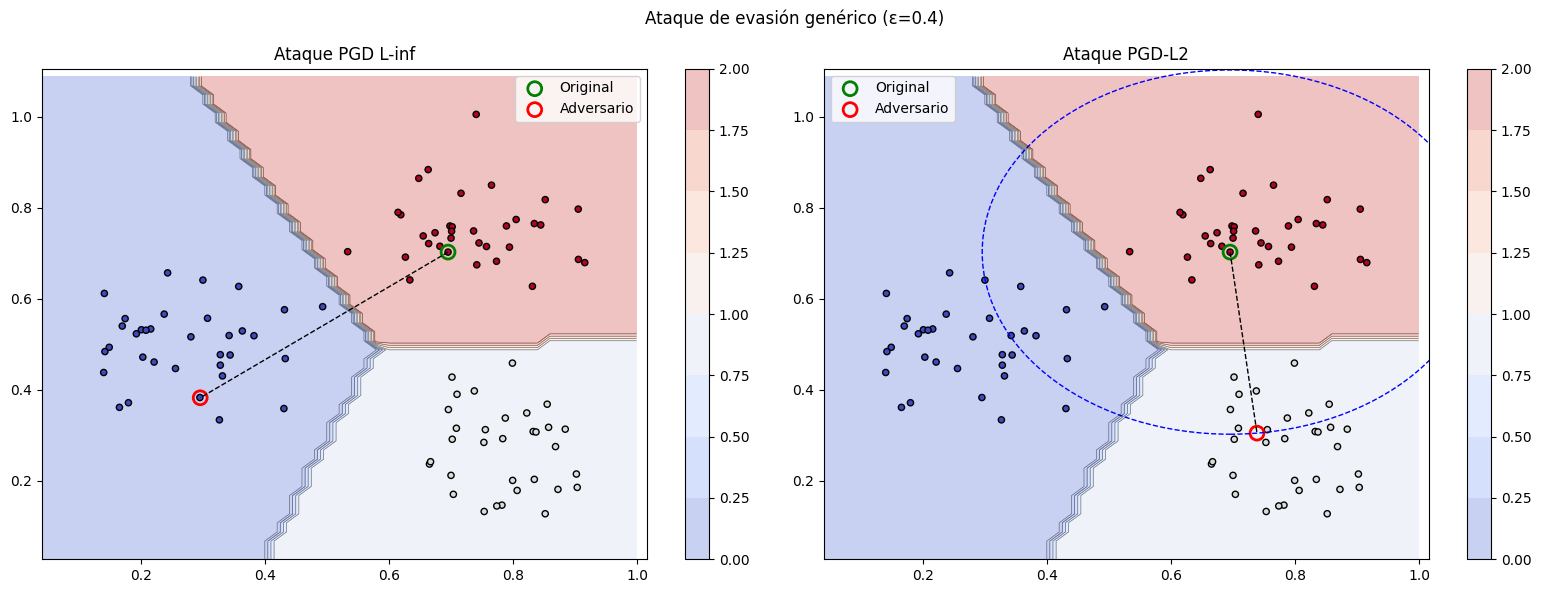

In [ ]:
def plot_decision_regions(ax, model, X, y, x0, adv, dmax, attack_name):
    # grid para visualización
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # predecimos clases para cada punto del grid
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    with torch.no_grad():
        logits = model(torch.FloatTensor(grid_points))
        Z = torch.argmax(logits, dim=1).numpy()
    Z = Z.reshape(xx.shape)

    # dibujar regiones de decisión y contornos
    contour = ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    ax.contour(xx, yy, Z, colors='black', linewidths=0.5, alpha=0.5)

    # visualizar la nube de puntos
    ax.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolors='k', cmap=plt.cm.coolwarm)

    # marcar el punto original y el adversario
    ax.scatter(x0[0, 0], x0[0, 1], s=100, facecolors='none', edgecolors='green', linewidths=2, label='Original')
    ax.scatter(adv[0, 0], adv[0, 1], s=100, facecolors='none', edgecolors='red', linewidths=2, label='Adversario')

    # línea desde x0 a adv
    ax.plot([x0[0, 0], adv[0, 0]], [x0[0, 1], adv[0, 1]], 'k--', linewidth=1)

    # restricción L2 (circulo)
    if "L2" in attack_name:
        circle = plt.Circle((x0[0, 0], x0[0, 1]), dmax, fill=False, color='blue', linestyle='--', linewidth=1)
        ax.add_artist(circle)

    # colorbar para valores de confianza
    plt.colorbar(contour, ax=ax)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(f"Ataque {attack_name}")
    ax.legend()

plt.figure(figsize=(16, 6))
ax1 = plt.subplot(1, 2, 1)
plot_decision_regions(ax1, model, X_test, y_test, x0, adv_pgd_np, dmax, "PGD L-inf")

ax2 = plt.subplot(1, 2, 2)
plot_decision_regions(ax2, model, X_test, y_test, x0, adv_pgdls_np, dmax, "PGD-L2")

plt.suptitle(f"Ataque de evasión genérico (ε={dmax})")
plt.tight_layout()
plt.show()